In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn as sns

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
health_file_path = 'Nutrition_Physical_Activity_and_Obesity_Data.csv'  # Replace with the path to your health CSV file
stock_file_path = 'all_stock_and_etfs.csv'  # Replace with the path to your stock/ETF CSV file

In [21]:
health_df = pd.read_csv(health_file_path, low_memory=False)
    
health_df.dropna(subset=['Data_Value', 'YearStart', 'Sample_Size'], inplace=True)

health_df['YearStart'] = health_df['YearStart'].astype(int)
health_df['Data_Value'] = pd.to_numeric(health_df['Data_Value'], errors='coerce')
health_df['Sample_Size'] = pd.to_numeric(health_df['Sample_Size'], errors='coerce')

health_df = health_df[['YearStart', 'Topic', 'Data_Value', 'Sample_Size']]

health_df

,YearStart,Topic,Data_Value,Sample_Size
0,2019,Physical Activity - Behavior,9.6,130.0
1,2019,Obesity / Weight Status,13.3,1739.0
2,2019,Obesity / Weight Status,17.1,8978.0
3,2019,Physical Activity - Behavior,65.9,876.0
4,2019,Obesity / Weight Status,16.7,2573.0
...,...,...,...,...
133340,2022,Obesity / Weight Status,24.5,111.0
133341,2022,Physical Activity - Behavior,36.0,159.0
133342,2022,Obesity / Weight Status,35.2,450.0
133343,2022,Obesity / Weight Status,35.3,512.0


In [22]:
stock_df = pd.read_csv(stock_file_path)
    
stock_df['Date-Time'] = pd.to_datetime(stock_df['Date-Time'])

stock_df['Year'] = stock_df['Date-Time'].dt.year

stock_df = stock_df[['Year', 'Ticker_Symbol', 'Close']]

stock_df

,Year,Ticker_Symbol,Close
0,2024,HRL,29.44
1,2024,HRL,28.99
2,2024,HRL,29.11
3,2024,HRL,28.80
4,2024,HRL,28.72
...,...,...,...
163552,1999,ALG,9.50
163553,1999,ALG,9.31
163554,1999,ALG,9.19
163555,1999,ALG,8.88


In [23]:
stock_df = stock_df.groupby(['Year', 'Ticker_Symbol']).mean().reset_index()

stock_df

,Year,Ticker_Symbol,Close
0,1999,ADM,12.453953
1,1999,AGCO,12.470930
2,1999,ALG,9.586512
3,1999,CAG,23.396744
4,1999,CAT,49.461860
...,...,...,...
693,2024,TSN,54.222353
694,2024,VMI,230.129706
695,2024,VOO,447.759459
696,2024,WEN,19.127059


In [24]:
def weighted_mean(df, value_col, weight_col):
    d = df[value_col]
    w = df[weight_col]
    return (d * w).sum() / w.sum()

def compute_yearly_weighted_averages(df, topics):
    yearly_data = pd.DataFrame()
    for topic in topics:
        topic_df = df[df['Topic'] == topic]
        yearly_topic = topic_df.groupby('YearStart').apply(lambda x: pd.Series({
            f'{topic}_Weighted_Avg': weighted_mean(x, 'Data_Value', 'Sample_Size')
        })).reset_index()
        
        if yearly_data.empty:
            yearly_data = yearly_topic
        else:
            yearly_data = pd.merge(yearly_data, yearly_topic, on='YearStart', how='outer')
    
    yearly_data.rename(columns={'YearStart': 'Year'}, inplace=True)
    return yearly_data

topics = ['Sugar Drinks - Behavior', 'Obesity / Weight Status', 'Fruits and Vegetables - Behavior', 'Physical Activity - Behavior']  
health_yearly_avg = compute_yearly_weighted_averages(health_df, topics)

/var/folders/1x/443khrvj3wxbl0fy_v6jmhjh0000gn/T/ipykernel_71587/255285709.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_topic = topic_df.groupby('YearStart').apply(lambda x: pd.Series({
/var/folders/1x/443khrvj3wxbl0fy_v6jmhjh0000gn/T/ipykernel_71587/255285709.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_topic = topic_df.groupby('YearStart').apply(lambda x: pd.Series({
/var/fol

In [25]:
def merge_datasets(health_df, stock_df):
    stock_df_pivot = stock_df.pivot(index='Year', columns='Ticker_Symbol', values='Close').reset_index()
    merged_data = pd.merge(health_df, stock_df_pivot, on='Year', how='inner')
    return merged_data

merged_data = merge_datasets(health_yearly_avg, stock_df)
print("Merged Data:")
merged_data

Merged Data:
   Year  Sugar Drinks - Behavior_Weighted_Avg  \
0  2001                                   NaN   
1  2003                                   NaN   
2  2005                                   NaN   
3  2007                             30.638569   
4  2009                             27.579583   

   Obesity / Weight Status_Weighted_Avg  \
0                             11.981387   
1                             12.883433   
2                             13.293950   
3                             13.740227   
4                             13.310378   

   Fruits and Vegetables - Behavior_Weighted_Avg  \
0                                      36.863676   
1                                      38.357444   
2                                      39.694257   
3                                      40.673918   
4                                      39.052723   

   Physical Activity - Behavior_Weighted_Avg        ADM       AGCO        ALG  \
0                                  29.5

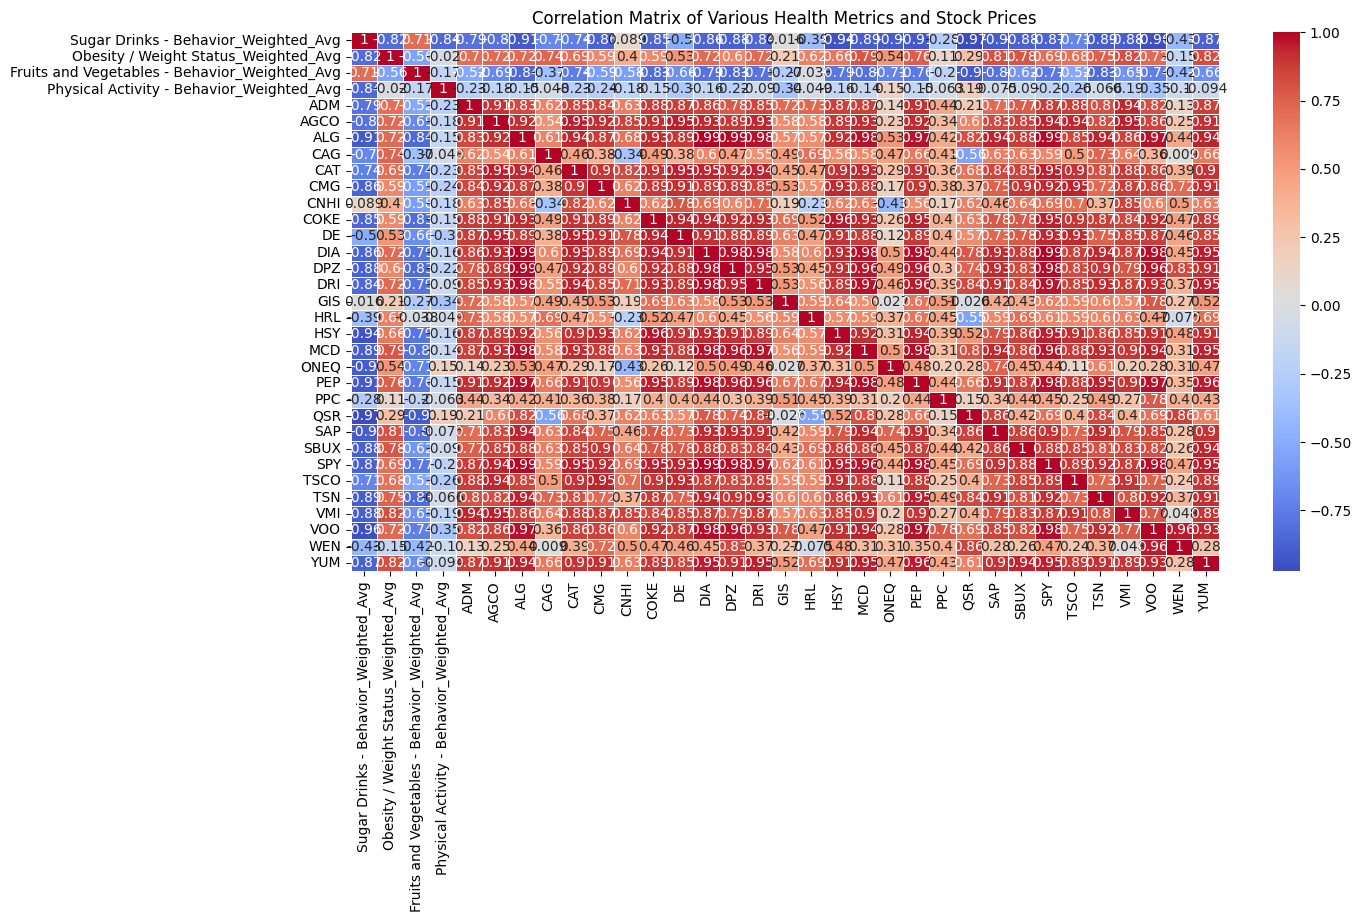

In [17]:
def plt_corr_matrix(df):
    numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Year'])    
    corr_matrix = numeric_df.corr()
    
    plt.figure(figsize=(14, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Various Health Metrics and Stock Prices')
    plt.show()
    
    return corr_matrix
corr_matrix = plt_corr_matrix(merged_data)

In [18]:
def identify_high_correlations(corr_matrix, threshold=0.5):
    health_metrics = [col for col in corr_matrix.columns if 'Weighted_Avg' in col]
    stock_symbols = [col for col in corr_matrix.columns if col not in health_metrics]
    
    high_corrs = []
    
    for metric in health_metrics:
        for stock in stock_symbols:
            corr_value = corr_matrix.at[metric, stock]
            if abs(corr_value) >= threshold:
                high_corrs.append((stock, metric, corr_value))
    
    high_corrs = sorted(high_corrs, key=lambda x: abs(x[2]), reverse=True)
    
    return high_corrs

high_corrs = identify_high_correlations(corr_matrix, threshold=0.5)
print("High Correlations:")
for stock, metric, corr_value in high_corrs:
    print(f"Stock: {stock}, Metric: {metric}, Correlation: {corr_value:.2f}")

High Correlations:
Stock: QSR, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.97
Stock: VOO, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.96
Stock: HSY, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.94
Stock: PEP, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.91
Stock: ALG, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.91
Stock: ONEQ, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.90
Stock: QSR, Metric: Fruits and Vegetables - Behavior_Weighted_Avg, Correlation: -0.90
Stock: SAP, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.90
Stock: TSN, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.89
Stock: MCD, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.89
Stock: VMI, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.88
Stock: DPZ, Metric: Sugar Drinks - Behavior_Weighted_Avg, Correlation: -0.88
Stock: SBUX, Metric: Sugar Drinks - Behavior_We